In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Introduction
We all know different types of classifiers/regressors like - Logistic Regression, SVM, Decision Trees etc. They are preety good at predicting and classification tasks but let's consider a scenario. Suppose, you pose a complex question to thousands of random people, then aggregate their answers. In many cases you will find that this aggregated answer is better than an expert’s answer. Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an ensemble; thus, this technique is called Ensemble Learning.

## Voting Classifiers / Ensemble learning using different predictors
Suppose, you have a trained multiple classifiers, each having a good accuracy, say 70%. A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a hard voting classifier.
<div>
<img src="https://i.imgur.com/vnV4NF5.png" width="500" align="center"/>
</div>

Even if the xlassifier is a weak learner(meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of
weak learners and they are sufficiently diverse.

Now, we discussed the hard-voting classifier, so is there any soft-voting classifier? Yes, If all classifiers are able to estimate class probabilities, then you can predict the class with the highest class probability, averaged over all the individual classifiers.
<div>
<img src="https://i.imgur.com/ik8B4un.png" width="500" align="center"/>
</div>

Sometimes, you could see no improvement in accuracy or even decrement in accuracy. But, if you will look at the net result, the model generally has similar bias but lower variance.
#### Ok, enough theory. Let's see it in action

------------------------------------------------------------------------------------------------------------------

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
data=pd.read_csv('../input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')

data['category'] = data['quality'] >= 7

X = data[data.columns[0:11]].values
Y = data['category'].values.astype(np.int)
data.head()

The wine quality is binarized into either "good" ( y=1 , quality>=7) or "not good" ( y=0 , quality<7). The input  X  consists of 11 features such as fixed acidity and pH. We will then split the data set into a trianing set and a test set:

In [ ]:
# let's standardize our data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

# Let's split our data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

print('X train size: ', x_train.shape)
print('y train size: ', y_train.shape)
print('X test size: ', x_test.shape)
print('y test size: ', y_test.shape)

The following code creates and trains a voting classifier in Scikit-Learn, composed of
three diverse classifiers.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score


dtc= DecisionTreeClassifier(random_state=0)
svc= SVC(random_state=0)
lr= LogisticRegression(random_state=0)

### Let's train our models separatly

In [ ]:
for clf in (dtc, lr, svc):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(f'{clf.__class__.__name__ } Accuracy Score  -  {accuracy_score(y_test, y_pred)}')
    print(f'{clf.__class__.__name__ } Precision Score  -  {precision_score(y_test,y_pred)}')
    print()

In [ ]:
# Now, let's use the ensemble method
voting_clf = VotingClassifier(estimators=[('lr', lr), ('dtc', dtc), ('svc', svc)],voting='hard')
voting_clf.fit(x_train, y_train)
y_pred = voting_clf.predict(x_test)
print(f'{voting_clf.__class__.__name__ } Accuracy Score  -  {accuracy_score(y_test, y_pred)}')
print(f'{voting_clf.__class__.__name__ } Precision Score  -  {precision_score(y_test,y_pred)}')

We can clearly see that Ensemble Model worked better with improved Accuracy and Precision Score.

------------------------------------------------------------------------------------------------------------------


## Ensemble learning using same predictors
Now, a obvious question that appears is why always have different classifiers, why not have same classifiers and use ensemble method. We could definetely do that but we need to make sure that we have that diversity that we had in previous section with diffent classifiers. Let's discuss the multiple ways to achieve it.



### **1. Sampling the training instances**
### Bagging

The idea is to use the same training algorithm for every predictor and train them on different random subsets of the training set. When sampling is performed **with replacement**, this method is called **Bagging** (short for bootstrap aggregating). 
Here, **with replacement** means that training instaces can be sampled multiple times for the same predictor as well across the other predictors. 
<div>
<img src="https://i.imgur.com/aJDLWJy.png" width="800" align="center"/>
</div>

### Pasting
Pasting refers to the method of randomly sampling training instances without replacement. This means that, in a certain subsample, the same instance can only appear at most once within a predictor.

#### Let's see bagging in action -

------------------------------------------------------------------------------------------------------------------

In [ ]:
# Splliting our data
x_train, x_test, y_train, y_test = train_test_split(X , Y, test_size=0.2,random_state=42)

print('X train size: ', x_train.shape)
print('y train size: ', y_train.shape)
print('X test size: ', x_test.shape)
print('y test size: ', y_test.shape)

In [ ]:
# First, training a single predictor
lr=LogisticRegression(random_state=0, solver='lbfgs')
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print(f'{lr.__class__.__name__ } Accuracy Score  -  {accuracy_score(y_test, y_pred)}')
print(f'{lr.__class__.__name__ } Precision Score  -  {precision_score(y_test,y_pred)}')

In [ ]:
# Now, let's have an ensemble of 500  logistic regression classifiers with the bagging method
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(LogisticRegression(random_state=0, solver='lbfgs'), 
                            n_estimators = 500,
                            oob_score = True, # We will see what it is in a bit
                            random_state = 90) 
bag_clf.fit(x_train, y_train)
y_pred = bag_clf.predict(x_test)
print(f'{bag_clf.__class__.__name__ } OOB Score  -  {bag_clf.oob_score_ }')

------------------------------------------------------------------------------------------------------------------

As expected, bagging performed better. Just one more thing to look on
#### Out-Of-Bag Evaluation
With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a BaggingClassifier samples m training instances with replacement (bootstrap=True), where m is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors.

Since a predictor never sees the oob instances during training, it can be evaluated on
these instances, without the need for a separate validation set. You can evaluate the
ensemble itself by averaging out the oob evaluations of each predictor.

### **2. Sampling the training features**
Instead of sampling the instances we can also sample the features. Sampling is
controlled by two hyperparameters: **max_features** and **bootstrap_features**. They
work the same way as **max_samples** and **bootstrap** (in Scikit Learn), but for feature sampling instead of
instance sampling. Thus, each predictor will be trained on a random subset of the input
features. Sampling features results in even more predictor diversity, trading a bit more bias for a
lower variance.

Sampling both training instances and features is called the **Random
Patches** method. Keeping all training instances but sampling features is called the **Random Subspaces
method**.

------------------------------------------------------------------------------------------------------------------

In [ ]:
bag_clf = BaggingClassifier(LogisticRegression(random_state=0, solver='lbfgs'), n_estimators = 500, 
                           bootstrap_features = True, max_features = 1.0, oob_score = True, random_state = 90)
bag_clf.fit(x_train, y_train)
print(f'{bag_clf.__class__.__name__ } OOB Score  -  {bag_clf.oob_score_ }')


Here, the OOB score went down, but still it's preforming equally. We can do hyperparameter tuning to imporve the performance furthur.

------------------------------------------------------------------------------------------------------------------

### **3. Boosting**
Boosting refers to any Ensemble method that can
combine several weak learners into a strong learner. The general idea of most boosting
methods is to train predictors sequentially, each trying to correct its predecessor. There
are many boosting methods available, but by far the most popular are **AdaBoost** (short
for Adaptive Boosting) and **Gradient Boosting**.
### AdaBoost
One way for a new predictor to correct its predecessor is to pay a bit more attention to
the training instances that the predecessor underfitted. This results in new predictors
focusing more and more on the hard cases. This is the technique used by AdaBoost.

For example, when training an AdaBoost classifier, the algorithm first trains a base
classifier (such as a Decision Tree) and uses it to make predictions on the training set.
The algorithm then increases the relative weight of misclassified training instances.
Then it trains a second classifier, using the updated weights, and again makes
predictions on the training set, updates the instance weights, and so on.
<div>
<img src="https://i.imgur.com/zUWqFz2.jpg" width="800" align="center"/>
</div>
<!-- 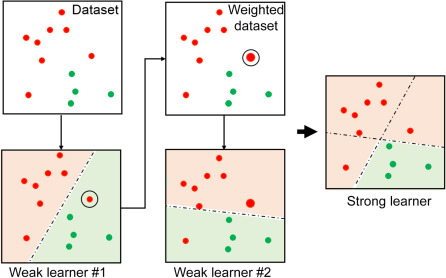 -->




This sequential learning technique has some
similarities with Gradient Descent, except that instead of tweaking a single predictor’s
parameters to minimize a cost function, AdaBoost adds predictors to the ensemble,
gradually making it better.

You can see how AdaBoost Algo works [here](https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/)

**Let's see how it works.**

------------------------------------------------------------------------------------------------------------------

In [ ]:
# First, training a single predictor
dtc=DecisionTreeClassifier(random_state=0)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
print(f'{dtc.__class__.__name__ } Accuracy Score  -  {accuracy_score(y_test, y_pred)}')
print(f'{dtc.__class__.__name__ } Precision Score  -  {precision_score(y_test,y_pred)}')

In [ ]:
# Let's now use AdaBoost
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=0), n_estimators=200,algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(x_train, y_train)
y_pred = ada_clf.predict(x_test)
print(f'{ada_clf.__class__.__name__ } Accuracy Score  -  {accuracy_score(y_test, y_pred)}')
print(f'{ada_clf.__class__.__name__ } Precision Score  -  {precision_score(y_test,y_pred)}')

AdaBoost Improved the performance

If the predictors can estimate
class probabilities (i.e., if they have a predict_proba() method) like DecisionTreeClassifier here, Scikit-Learn can use
a variant of SAMME called SAMME.R (the R stands for “Real”), which relies on class
probabilities rather than predictions and generally performs better

------------------------------------------------------------------------------------------------------------------

### Gradient Boosting
Just like **AdaBoost**,
**Gradient Boosting** works by sequentially adding predictors to an ensemble, each one
correcting its predecessor. However, instead of tweaking the instance weights at every
iteration like AdaBoost does, this method tries to fit the new predictor to the residual
errors made by the previous predictor.
<div>
<img src="https://i.imgur.com/cXXmSQB.png" width="500" align="center"/>
</div>


------------------------------------------------------------------------------------------------------------------

In [ ]:
# First, training a single predictor
dtc=DecisionTreeClassifier(random_state=0)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
print(f'{dtc.__class__.__name__ } Accuracy Score  -  {accuracy_score(y_test, y_pred)}')
print(f'{dtc.__class__.__name__ } Precision Score  -  {precision_score(y_test,y_pred)}')

In [ ]:
# Let's now use Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(max_depth=2, n_estimators=200, learning_rate=1.0)
gbrt.fit(x_train, y_train)
y_pred = gbrt.predict(x_test)
print(f'{gbrt.__class__.__name__ } Accuracy Score  -  {accuracy_score(y_test, y_pred)}')
print(f'{gbrt.__class__.__name__ } Precision Score  -  {precision_score(y_test,y_pred)}')

The GradientBoostingClassifier class also supports a subsample hyperparameter,
which specifies the fraction of training instances to be used for training each tree. For
example, if subsample=0.25, then each tree is trained on 25% of the training instances,
selected randomly. As you can probably guess by now, this technique trades a higher
bias for a lower variance. It also speeds up training considerably. This is called
**Stochastic Gradient Boosting**.

------------------------------------------------------------------------------------------------------------------

### Extreme Gradient Boosting (XGBoost)
It is an optimized implementation of **Gradient Boosting** based on Decision-Tree ensemble and stands for Extreme Gradient Boosting. It aims to be extremely fast, scalable, and
portable. In fact, XGBoost is often an important component of the winning entries in
ML competitions. To know how it perfrom better go [here](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

------------------------------------------------------------------------------------------------------------------

In [ ]:
import xgboost
xgb_reg = xgboost.XGBClassifier(eval_metric='mlogloss')
xgb_reg.fit(x_train, y_train)
y_pred = xgb_reg.predict(x_test)
print(f'{xgb_reg.__class__.__name__ } Accuracy Score  -  {accuracy_score(y_test, y_pred)}')
print(f'{xgb_reg.__class__.__name__ } Precision Score  -  {precision_score(y_test,y_pred)}')

As we can see, it's far better than any other ensemble technique.

**Bear with me, we are just left with 1 more ensumble technique.**

------------------------------------------------------------------------------------------------------------------

### **4. Stacking**
It is based on a simple idea: instead of using trivial functions
(such as hard voting) to aggregate the predictions of all predictors in an ensemble, why
don’t we train a model to perform this aggregation? 

We can have such an
ensemble performing a regression task on a new instance. Each of the
predictors predicts a different value, and then the final predictor
(called a **blender**, or a **meta learner**) takes these predictions as inputs and makes the
final prediction.
<div>
<img src="https://i.imgur.com/2vp8IP0.png" width="500" align="center"/>
</div>


To train the blender, a common approach is to use a hold-out set. Let’s see how it
works. 

First, the training set is split into two subsets. The first subset is used to train the
predictors in the first layer.

Next, the first layer’s predictors are used to make predictions on the second (held-out)
set. We can create a new training set using these predicted values
as input features, and keeping the target values.
The blender is trained on this new training set, so it learns to predict the target value,
given the first layer’s predictions.

### **Let's implement the stacking**

------------------------------------------------------------------------------------------------------------------

In [ ]:
from sklearn.ensemble import StackingClassifier
estimators = [
            ('rf', RandomForestClassifier(n_estimators=10, random_state=0)),
            ('svr',SVC(random_state=0))
            ]
clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression()
        )
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(f'{clf.__class__.__name__ } Accuracy Score  -  {accuracy_score(y_test, y_pred)}')
print(f'{clf.__class__.__name__ } Precision Score  -  {precision_score(y_test,y_pred)}')

------------------------------------------------------------------------------------------------------------------

# That's all folks! 
### You now have the basic idea about the different Ensemble Techniques. Make sure to apply them on your own and read some articles for in-depth Understanding.



![Imgur](https://i.imgur.com/N39ixv7.png)